<a href="https://colab.research.google.com/github/rizalpangestu1/Machine-Learning/blob/main/Copy_of_GymLens_Training_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, Callback
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from ipywidgets import FileUpload
import io

In [11]:
# Mount Google Drive
drive.mount('/content/drive')
# Dataset directory
DATASET_DIR = '/content/drive/MyDrive/Gym Dataset Cropped'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


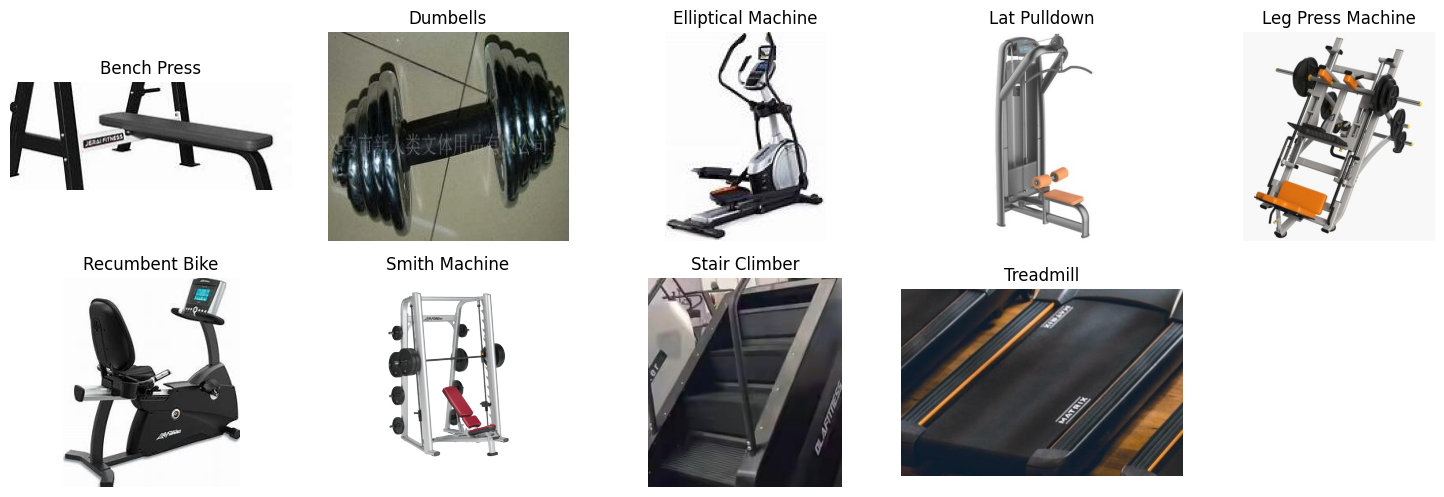

In [13]:
import os

def convert_all_images_to_rgba(dataset_dir):
    """
    Convert all images in a dataset directory to RGBA if necessary.

    Parameters:
    - dataset_dir: Path to the dataset directory.
    """
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                # Convert to RGBA if necessary
                if img.mode in ('P', 'L', 'LA') or ('transparency' in img.info):
                    img = img.convert('RGBA')
                    img.save(file_path)  # Overwrite the original file
                    print(f"Converted: {file_path}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Path to your dataset
DATASET_DIR = '/content/drive/MyDrive/C242-PS284/Gym Dataset Cropped'

# Convert all images
convert_all_images_to_rgba(DATASET_DIR)

# Function to display sample images
def display_sample_images(data_dir, max_classes=19):
    """
    Display one sample image from each class in the dataset.
    """
    try:
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        plt.figure(figsize=(15, 10))

        for i, cls in enumerate(classes[:max_classes]):
            cls_path = os.path.join(data_dir, cls)
            if os.path.isdir(cls_path):
                image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
                if image_files:
                    image_path = os.path.join(cls_path, image_files[0])
                    img = preprocess_image(image_path)

                    plt.subplot(4, 5, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying images: {e}")

# Display sample images
display_sample_images(DATASET_DIR)


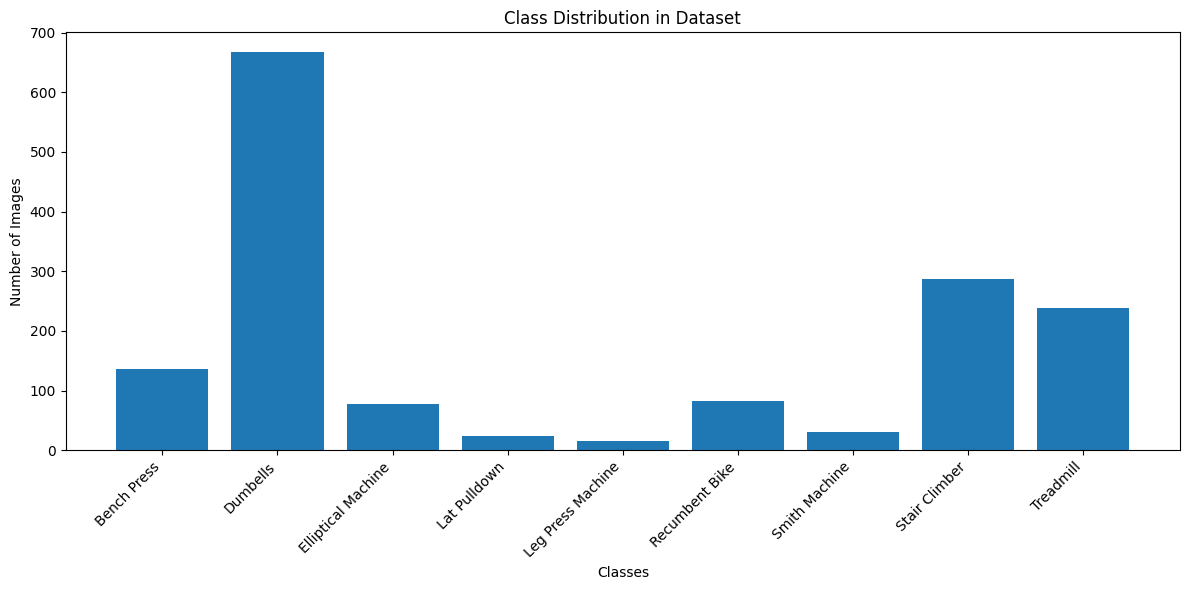

In [14]:
def plot_class_distribution(data_dir):
    """
    Plot the distribution of images across classes in the dataset.

    Parameters:
    - data_dir: Path to the dataset directory where each class has its own subdirectory.
    """
    try:
        # List all classes (subdirectories) in the dataset directory
        classes = [cls for cls in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, cls))]
        class_counts = []

        # Count the number of images in each class
        for cls in classes:
            cls_path = os.path.join(data_dir, cls)
            num_images = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
            class_counts.append(num_images)

        # Plot the distribution
        plt.figure(figsize=(12, 6))
        plt.bar(classes, class_counts, tick_label=classes)
        plt.xticks(rotation=45, ha='right')
        plt.title('Class Distribution in Dataset')
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting class distribution: {e}")

# Plot class distribution
plot_class_distribution(DATASET_DIR)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

minority_classes = [
    "Bench Press", "Elliptical Machine", "Lat Pulldown",
    "Leg Press Machine", "Recumbent Bike", "Smith Machine",
    "Stair Climber", "Treadmill"
]

base_dir = '/content/drive/MyDrive/Gym Dataset Cropped'
augmented_dir = '/content/drive/MyDrive/Augmented Gym Dataset'

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment images for minority classes
for cls in minority_classes:
    cls_dir = os.path.join(base_dir, cls)
    aug_dir = os.path.join(augmented_dir, cls)
    os.makedirs(aug_dir, exist_ok=True)

    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        img = load_img(img_path, target_size=(128, 128))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate and save augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=aug_dir, save_prefix=cls, save_format='jpeg'):
            i += 1
            if i >= 20:  # Generate 20 augmented images per original image
                break


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


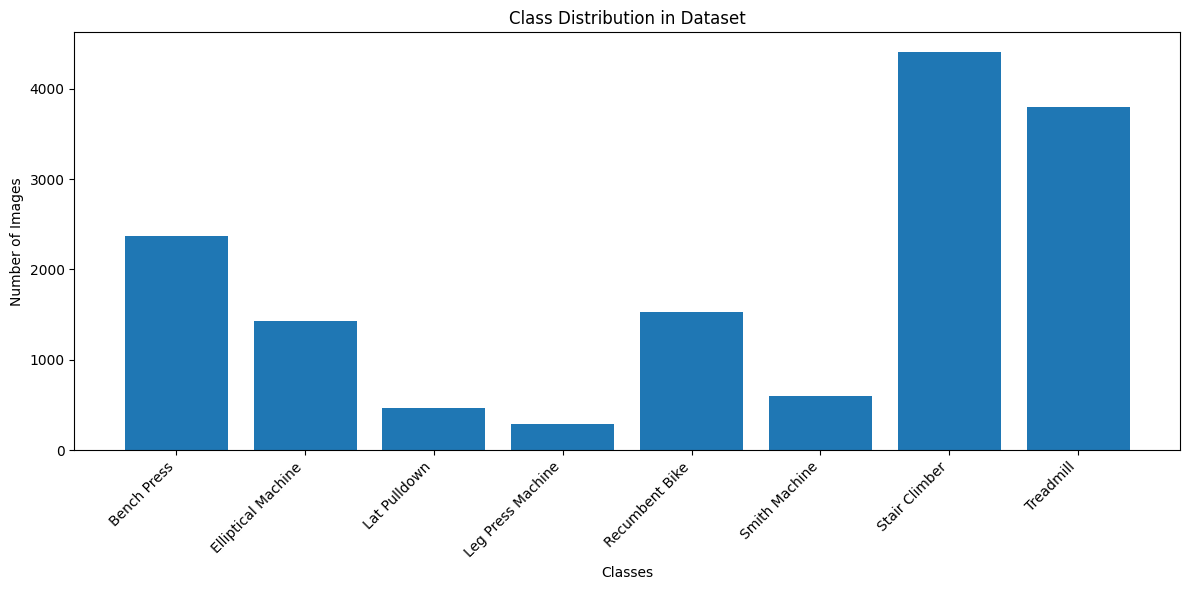

In [16]:
# Plot class distribution
plot_class_distribution(augmented_dir)

In [19]:
import os
import shutil

def move_augmented_data(augmented_dir, target_dir):
    """
    Move files from augmented_dir to target_dir while preserving class folder structure.

    Parameters:
    - augmented_dir: Path to the directory with augmented data (source).
    - target_dir: Path to the dataset directory (destination).
    """
    try:
        # Loop over each class in the augmented directory
        for cls in os.listdir(augmented_dir):
            cls_path = os.path.join(augmented_dir, cls)

            # Ensure it's a directory
            if os.path.isdir(cls_path):
                target_cls_path = os.path.join(target_dir, cls)
                os.makedirs(target_cls_path, exist_ok=True)  # Create target class directory if it doesn't exist

                # Move each file in the class directory
                for file in os.listdir(cls_path):
                    src_file = os.path.join(cls_path, file)
                    dest_file = os.path.join(target_cls_path, file)
                    shutil.move(src_file, dest_file)
                    print(f"Moved: {src_file} -> {dest_file}")

        print("All files moved successfully!")
    except Exception as e:
        print(f"Error while moving files: {e}")

# Set source (augmented_dir) and destination (DATASET_DIR)
augmented_dir = '/content/drive/MyDrive/Augmented Gym Dataset'
DATASET_DIR = '/content/drive/MyDrive/Gym Dataset Cropped'

# Move files
move_augmented_data(augmented_dir, DATASET_DIR)


Streaming output truncated to the last 5000 lines.
Moved: /content/drive/MyDrive/Augmented Gym Dataset/Stair Climber/Stair Climber_0_4071.jpeg -> /content/drive/MyDrive/Gym Dataset Cropped/Stair Climber/Stair Climber_0_4071.jpeg
Moved: /content/drive/MyDrive/Augmented Gym Dataset/Stair Climber/Stair Climber_0_2738.jpeg -> /content/drive/MyDrive/Gym Dataset Cropped/Stair Climber/Stair Climber_0_2738.jpeg
Moved: /content/drive/MyDrive/Augmented Gym Dataset/Stair Climber/Stair Climber_0_6235.jpeg -> /content/drive/MyDrive/Gym Dataset Cropped/Stair Climber/Stair Climber_0_6235.jpeg
Moved: /content/drive/MyDrive/Augmented Gym Dataset/Stair Climber/Stair Climber_0_3019.jpeg -> /content/drive/MyDrive/Gym Dataset Cropped/Stair Climber/Stair Climber_0_3019.jpeg
Moved: /content/drive/MyDrive/Augmented Gym Dataset/Stair Climber/Stair Climber_0_1982.jpeg -> /content/drive/MyDrive/Gym Dataset Cropped/Stair Climber/Stair Climber_0_1982.jpeg
Moved: /content/drive/MyDrive/Augmented Gym Dataset/Stair C

In [20]:
# Data Generators
batch_size = 128
train_datagen = ImageDataGenerator(
    validation_split=0.2,  # Split 20% for validation
    rescale=1.0 / 255,  # Normalize pixel values
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),  # Smaller input size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print("Number of classes:", len(train_generator.class_indices))
print("Number of training images:", train_generator.n)
print("Number of validation images:", validation_generator.n)


Found 13166 images belonging to 9 classes.
Found 3287 images belonging to 9 classes.
Number of classes: 9
Number of training images: 13166
Number of validation images: 3287


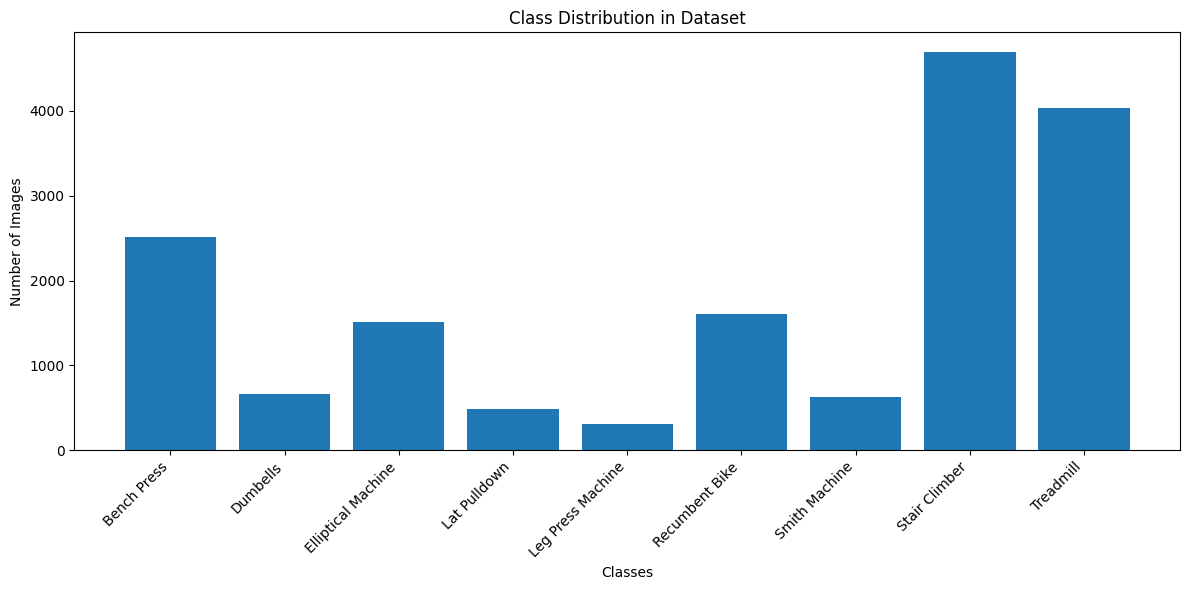

In [21]:
# Plot class distribution
plot_class_distribution(DATASET_DIR)

In [22]:
# Define the model using MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model to speed up training

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
# EarlyStoppingCallback for accuracy >= 98%
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc and val_acc >= self.target_accuracy:
            print(f"\nStopping training as validation accuracy reached {val_acc:.2f} (≥ {self.target_accuracy:.2f})")
            self.model.stop_training = True

early_stopping = EarlyStoppingAtAccuracy(target_accuracy=0.999)

In [24]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
 78/103 [=====================>........] - ETA: 1:07 - loss: 0.2657 - accuracy: 0.9155

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


103/103 [==============================] - 339s 3s/step - loss: 0.2184 - accuracy: 0.9302 - val_loss: 0.0732 - val_accuracy: 0.9754
Epoch 2/10
103/103 [==============================] - 115s 1s/step - loss: 0.0485 - accuracy: 0.9840 - val_loss: 0.0444 - val_accuracy: 0.9875
Epoch 3/10
103/103 [==============================] - 113s 1s/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.0380 - val_accuracy: 0.9869
Epoch 4/10
103/103 [==============================] - 112s 1s/step - loss: 0.0247 - accuracy: 0.9907 - val_loss: 0.0458 - val_accuracy: 0.9836
Epoch 5/10
103/103 [==============================] - 113s 1s/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0236 - val_accuracy: 0.9912
Epoch 6/10
103/103 [==============================] - 112s 1s/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0261 - val_accuracy: 0.9909
Epoch 7/10
103/103 [==============================] - 113s 1s/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0193 - val_accuracy: 0.9927
Epoch 8/10

In [25]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

26/26 [==============================] - 22s 860ms/step - loss: 0.0253 - accuracy: 0.9897
Validation Loss: 0.025258800014853477
Validation Accuracy: 0.9896562099456787


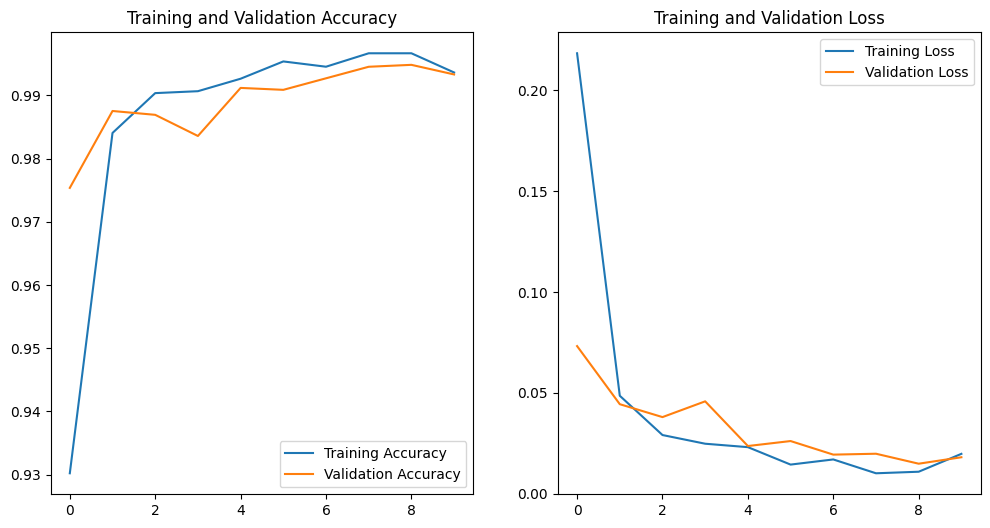

In [26]:
# Plot training history
def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss over epochs.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

1/1 [==============================] - 0s 34ms/step


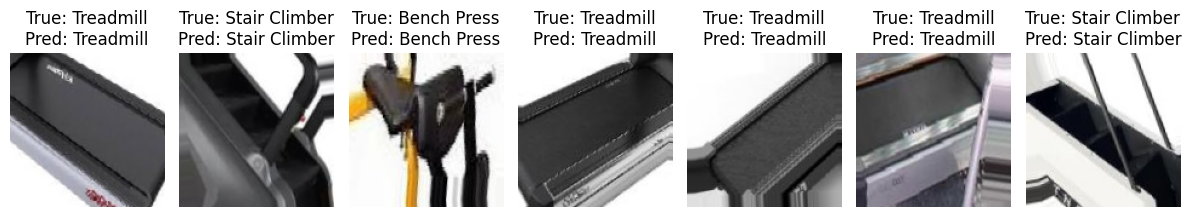

In [27]:
# Test with some validation images
def test_model_with_sample_images(validation_generator, model, num_samples=7):
    """
    Display predictions on sample validation images along with true labels.
    """
    # Get a batch of images and labels from the validation set
    images, labels = next(validation_generator)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = images[i]
        label = labels[i]

        # Predict the class of the image
        prediction = model.predict(img.reshape(1, *img.shape))
        predicted_label = list(validation_generator.class_indices.keys())[prediction.argmax()]
        true_label = list(validation_generator.class_indices.keys())[label.argmax()]

        # Display the image with the predicted and true labels
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on sample images
test_model_with_sample_images(validation_generator, model)

In [28]:
# Generate predictions and true labels from the test set
def evaluate_on_test_set(model, test_generator):
    """
    Generate predictions on the test set and display a confusion matrix.

    Parameters:
    - model: Trained Keras model.
    - test_generator: Data generator for the test set.

    Returns:
    - y_true: True labels.
    - y_pred: Predicted labels.
    """
    # Get predictions and true labels
    y_pred = []
    y_true = []

    for images, labels in test_generator:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels, axis=1))

        # Break when we've iterated over all samples
        if len(y_true) >= test_generator.n:
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
    disp.plot(xticks_rotation='vertical', cmap='viridis')

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

    return y_true, y_pred


Found 16453 images belonging to 9 classes.
3/3 [==============================] - 0s 39ms/step

Classification Report:
                    precision    recall  f1-score   support

       Bench Press       1.00      1.00      1.00      2508
          Dumbells       1.00      1.00      1.00       667
Elliptical Machine       1.00      0.98      0.99      1509
      Lat Pulldown       1.00      1.00      1.00       491
 Leg Press Machine       1.00      1.00      1.00       307
    Recumbent Bike       0.98      1.00      0.99      1611
     Smith Machine       1.00      1.00      1.00       633
     Stair Climber       1.00      1.00      1.00      4690
         Treadmill       1.00      1.00      1.00      4037

          accuracy                           1.00     16453
         macro avg       1.00      1.00      1.00     16453
      weighted avg       1.00      1.00      1.00     16453



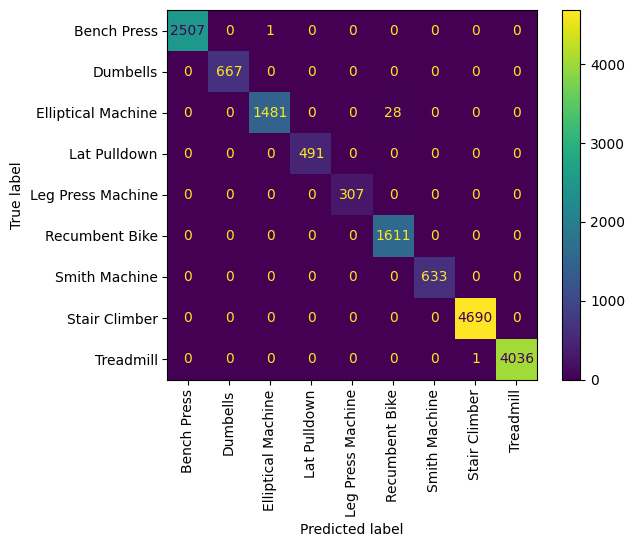

In [29]:
# Test Generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescaling
test_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Maintain order for accurate results
)

# Evaluate the model on the test set
y_true, y_pred = evaluate_on_test_set(model, test_generator)

In [34]:
def upload_and_test(model, target_size, class_indices):
    """
    Upload file, preprocess, and predict using the trained model.

    Parameters:
    - model: Trained Keras model.
    - target_size: Tuple (width, height) for resizing the input image.
    - class_indices: Dictionary of class labels and indices.

    Returns:
    None
    """
    # Upload file widget
    uploader = FileUpload(accept='image/*', multiple=False)
    display(uploader)

    def on_upload(change):
        # Load and preprocess the uploaded image
        for name, file_info in uploader.value.items():
            img = Image.open(io.BytesIO(file_info['content'])) # 'io' is now defined
            img = img.resize(target_size)  # Resize image to match model input size
            img_array = img_to_array(img) / 255.0  # Normalize image data
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input

            # Predict
            prediction = model.predict(img_array)
            predicted_label = list(class_indices.keys())[np.argmax(prediction)]
            confidence = np.max(prediction)

            # Show the uploaded image and prediction
            plt.imshow(img)
            plt.title(f"Prediction: {predicted_label} ({confidence*100:.2f}%)")
            plt.axis('off')
            plt.show()

    uploader.observe(on_upload, names='value')

FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 0s 49ms/step


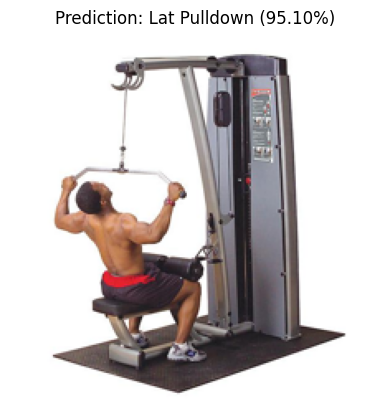

1/1 [==============================] - 0s 47ms/step


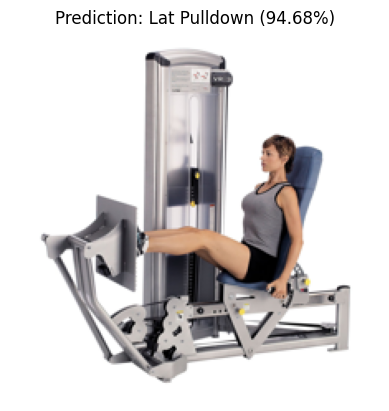

1/1 [==============================] - 0s 46ms/step


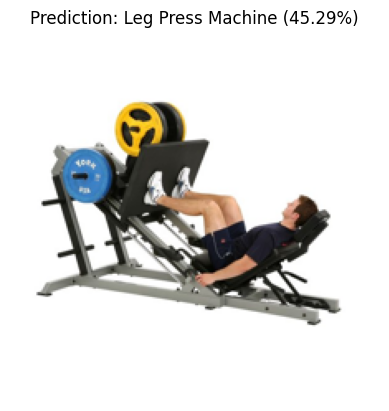

1/1 [==============================] - 0s 45ms/step


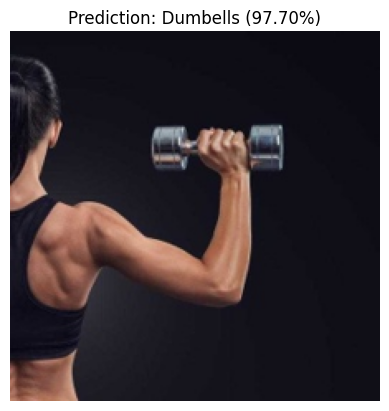

In [35]:
upload_and_test(model, target_size=(224, 224), class_indices=validation_generator.class_indices)


In [ ]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/saved_model/gym_model_MobileNetV2.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")